<a href="https://colab.research.google.com/github/PHastings37/Mphys-proj/blob/main/Visualizing_and_Analyzing_DICOM_Images_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RORY FARWELL 16/10/2021

This is the basis/beginning code for my project. In aid of Google Drive storage space saving, I have only uploaded 10 patients worth of data (in order that they were downloaded from using the 'NBIA Data Retreiver' app. To avoid any confusion, the data set being used by me is the NSCLC-Radiomics set from TCIA.

Using information provided on the site : https://hengloose.medium.com/a-comprehensive-starter-guide-to-visualizing-and-analyzing-dicom-images-in-python-7a8430fcb7ed .

Note to self: another useful site, which may be useful later on is : https://towardsdatascience.com/a-python-script-to-sort-dicom-files-f1623a7f40b8 .

In [1]:
"""
The first two cells connect this Colab Notebook to your drive and then sets the path to your files

"""

from google.colab import drive
drive.mount('/content/gdrive')
#a change

Mounted at /content/gdrive


In [2]:
"""
NOTE : You may need to change this path to match the path of your own
Google Drive
"""
%cd /content/gdrive/MyDrive/MPhys/dicom-files

/content/gdrive/MyDrive/MPhys/dicom-files


In [3]:
"""
This cell downloads all the required packages for this process.
These are 

pydicom -> for reading DICOM files
numpy -> for computing applications
scipy -> also for computing applications
skimage -> for image processing functions
matplotlib -> for visualizations
plotly -> for interactive visualisations !!!NOT DONE NOW AS THIS REQUIRES A 
SIGN UP!!!
ipywidget -> for interactive plots

"""
!pip install pydicom
!pip install numpy
!pip install scipy
!pip install scikit-image
!pip install matplotlib
!pip install ipywidgets

     |████████████████████████████████| 2.0 MB 5.2 MB/s 


In [4]:
"""
This cell imports all the necessary packages

NOTE: plotly code not in use as this required a sign up process. 
Can perform this later on.
"""

# common packages
import numpy as np
import os
import copy
from math import *
import matplotlib.pyplot as plt
from functools import reduce

# for reading DICOM files
import pydicom

# skimage image processing packages
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops

# scipy linear algebra functions
from scipy.linalg import norm
import scipy.ndimage

# ipywidgets for some interactive plots
from ipywidgets.widgets import * 
import ipywidgets as widgets

"""# plotly 3D interactive graphs 
import plotly
from plotly.graph_objs import *
import chart_studio.plotly as py

# set plotly credentials here 
# this allows you to send results to your account
# plotly.tools.set_credentials_file(username=your_username, api_key=your_key)
"""

'# plotly 3D interactive graphs \nimport plotly\nfrom plotly.graph_objs import *\nimport chart_studio.plotly as py\n\n# set plotly credentials here \n# this allows you to send results to your account\n# plotly.tools.set_credentials_file(username=your_username, api_key=your_key)\n'

In [5]:
"""
This cell will load in DICOM images
"""

def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in               
              os.listdir(path)]
    slices = [s for s in slices if 'SliceLocation' in s]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] -   
                          slices[1].ImagePositionPatient[2])
    except:
      slice_thickness = np.abs(slices[0].SliceLocation - 
                      slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.32722.99.99.278123690005973021678550132607905417099
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.32722.99.99.2

'\nplt.figure(figsize=(10,10)) # specifying the overall grid size\n\nfor i in range(16):\n    plt.subplot(4,4,i+1)    # the number of images in the grid is 5*5 (25)\n    plt.imshow(patient_pixels[i], cmap=plt.cm.bone)\n\nplt.show()\n'

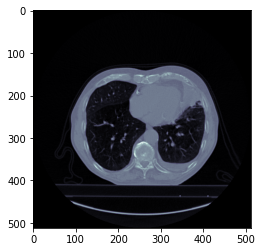

In [17]:
"""
Run this cell to extract DICOM pixels for each slice location and displaye 
a single slice

This has been adapted to print the data from the 1st DICOM file and gives the 
user the option to print all CTs in a grid if desired. This option is taken 
through editing of the code. 



!!!
WORKS WHEN USING THE 'one-dcm-file' FOLDER BUT NOT WHEN USING THE REAL FOLDERS. 
UNSURE WHY.

MAYBE COULD ADD AN INPUT TO ASK THE USER WHICH CT THEY WANT TO SEE. E.G. PICK A
NUMBER BETWEEN 0 AND 133.
!!!
"""

# set path and load files 
path = '/content/gdrive/MyDrive/MPhys/dicom-files/One-dcm-file' #set this as the path to your dicom directory
patient_dicom = load_scan(path)
patient_pixels = get_pixels_hu(patient_dicom)

#sanity check
plt.imshow(patient_pixels[80], cmap=plt.cm.bone) #prints the first scan ith scan in the array


print(patient_dicom[80]) #prints the DICOM for the first image

# The code below prints more than on of the CTs but I'm currently having issues
# with formatting all 134 of the scans of the first patient
"""
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(16):
    plt.subplot(4,4,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(patient_pixels[i], cmap=plt.cm.bone)

plt.show()
"""

In [9]:
"""
Now use some thresholding and morphological operations to segment just the lung 
from the chest
"""

def largest_label_volume(im, bg = -1) :
  vals, counts = np.unique(im, return_counts = True)

  counts = counts[vals != bg]
  vals = vals[vals != bg]
  
  if len(counts) > 0 :
    return vals[np.argmax(counts)]
  else :
    return None

def segment_lung_mask(image, fill_lung_structures = True) :
  # not actually binary but, 1 and 2
  # 0 is treated as background, which we do not want
  binary_image = np.array(image >= -700, dtype = np.int8)+1
  labels = measure.label(binary_image)

  # Pick the pixel in the very corner to determine which label is air
  # Improvement : Pick multiple background labels from around the patient
  # More resistant to "trays" on which the patient lays cutting the air around the person in half
  background_label = labels[0,0,0]

  # Fill the air around the person
  binary_image[background_label == labels] = 2

  # Method of filling the lung structures (that is superior to something like 
  # morphological closing)
  if fill_lung_structures :
    # For every slice we determine the largest solid structure
    for i, axial_slice in enumerate(binary_image) :
      axial_slice = axial_slice - 1
      labeling = measure.label(axial_slice)
      l_max = largest_label_volume(labeling, bg=0)

      if l_max is not None : #this slice contains some lung
        binary_image[i] [labeling != l_max] = 1
  binary_image -= 1 # Make the image actual binary
  binary_image = 1 - binary_image #invert it, lungs are now 1

  #Remove other air pockets inside body
  labels = measure.label(binary_image, background = 0)
  l_max = largest_label_volume(labels, bg=0)
  if l_max is not None : # There are air pockets
    binary_image[labels != l_max] = 0

  return binary_image


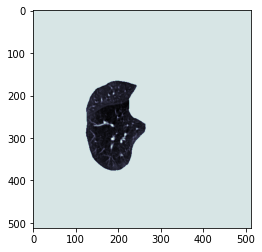

In [16]:
"""
!!!
CURRENTLY ONLY ISOLATES THE LEFT LUNG AND NOT SURE WHY
!!!
"""

# Get masks
segmented_lungs = segment_lung_mask(patient_pixels, fill_lung_structures = False)
segmented_lungs_fill = segment_lung_mask(patient_pixels, fill_lung_structures = True)
internal_structures = segmented_lungs_fill - segmented_lungs

# Isolate lung from chest
copied_pixels = copy.deepcopy(patient_pixels)
for i, mask in enumerate(segmented_lungs_fill) :
  get_high_vals = mask == 0
  copied_pixels[i] [get_high_vals] = 0
seg_lung_pixels = copied_pixels

# Sanity check
plt.imshow(seg_lung_pixels[80], cmap=plt.cm.bone)